# Pre-trained models benchmark

In [1]:
# SOME IMPORTS

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO

%matplotlib inline

In [2]:
# FUNCTION TO COMPUTE FLOPS, THERE IS AN ALTERNATIVE WITH THOP

def get_flops_with_torch_profiler(model, imgsz=640):
    """Compute model FLOPs (thop alternative)."""
    #model = de_parallel(model) in case of pasing DDP model, it transforms it to a single GPU model
    p = next(model.parameters())
    stride = (max(int(model.stride.max()), 32) if hasattr(model, 'stride') else 32) * 2  # max stride
    im = torch.zeros((1, p.shape[1], stride, stride), device=p.device)  # input image in BCHW format
    with torch.profiler.profile(with_flops=True) as prof:
        model(im)
    flops = sum(x.flops for x in prof.key_averages()) / 1E9
    imgsz = imgsz if isinstance(imgsz, list) else [imgsz, imgsz]  # expand if int/float
    flops = flops * imgsz[0] / stride * imgsz[1] / stride  # 640x640 GFLOPs
    return flops

In [3]:
def perform_benchmark(archs, dataset, devices, formats=['onnx', 'tensorrt']):
    # EMPTY LISTS TO STORE VALUES
    t_pre = []
    t_infer = []
    t_post = []
    maps = []
    params = []
    flops = []

    is_coco = 'coco.yaml' in dataset
    if is_coco:
        maps_small = []

    if 'onnx' in formats:
        o_t_pre = []
        o_t_infer = []
        o_t_post = []
        o_maps = []
        
    if 'tensorrt' in formats:
        r_t_pre = []
        r_t_infer = []
        r_t_post = []
        r_maps = []
    

    # PERFORM BENCHMARK OVER THE LIST OF SPECIFIED MODELS
    for arch in archs:
        # Register model
        model = YOLO('./../../models/'+arch+'.pt')
        # Evalute in validation dataset
        metrics = model.val(data=dataset, verbose=True, plots=False, save_json=True, cache=True, device=devices)
    
        # Get metrics in *.pt format
        t_pre.append(metrics.speed['preprocess'])
        t_infer.append(metrics.speed['inference'])
        t_post.append(metrics.speed['postprocess'])
        maps.append(metrics.box.map)
        params.append(model.info()[1])
        flops.append(get_flops_with_torch_profiler(model.model, imgsz=640)) # TODO adjust image size for P6 model.
        if is_coco:
            maps_small.append(metrics.box.map_small)
    
        if 'onnx' in formats:
            # Export to ONNX format
            filename = model.export(format='onnx', dynamic=False, half=False, int8=False, simplify=False, opset=None) #TODO: INVESTIGATE
            # Register and Evaluate exported model
            export = YOLO(filename, task=model.task)
            # TODO: changed Dataset bc it is very slow in onnx
            results = export.val(data=dataset, batch=1, plots=False, verbose=False, imgsz=model.overrides['imgsz'], device=devices)
    
            # Get metrics in *.onnx format
            o_t_pre.append(results.speed['preprocess'])
            o_t_infer.append(results.speed['inference'])
            o_t_post.append(results.speed['postprocess'])
            o_maps.append(results.box.map)
        
        if 'tensorrt' in formats:
            # Export to TensorRT
            filename = './../../models/'+arch+'.engine'
            if not os.path.isfile(filename):
                filename = model.export(format='engine', dynamic=False, half=False, int8=False, simplify=False, workspace=4, device=devices) #TODO: INVESTIGATE
            else:
                print('TensorRT model already exists, loading it ...')
            # Register and Evaluate exported model
            export = YOLO(filename, task=model.task)
            results = export.val(data=dataset, batch=1, plots=False, verbose=False, imgsz=model.overrides['imgsz'], device=devices)
        
            # Get metrics in *.engine format
            r_t_pre.append(results.speed['preprocess'])
            r_t_infer.append(results.speed['inference'])
            r_t_post.append(results.speed['postprocess'])
            r_maps.append(results.box.map)
        

    # BUILD DATAFRAME WITH THE OBTAINED RESULTS
    df = pd.DataFrame({
        'architecture': archs,
        'parameters': params,
        'FLOPs': flops,
        'preprocess': t_pre,
        'inference': t_infer,
        'postprocess': t_post,
        'mAP': maps,
    })
    # COMPUTE FPS USING INFERENCE TIME ONLY
    df['FPS'] = 1000/df.inference

    if is_coco:
        df = df.assign(mAP_small=maps_small)

    if 'onnx' in formats:
        df = df.assign(o_preprocess=o_t_pre, o_inference=o_t_infer, o_postprocess=o_t_post, o_mAP=o_maps)
        df['o_FPS'] = 1000/df.o_inference

    if 'tensorrt' in formats:
        df = df.assign(r_preprocess=r_t_pre, r_inference=r_t_infer, r_postprocess=r_t_post, r_mAP=r_maps)
        df['r_FPS'] = 1000/df.r_inference

    return df


In [4]:
# SETUP DATASET AND DEVICE
archs = ['yolov5s6u']    
#['yolov8n', 'yolov8s', 'yolov8m', 'yolov5nu', 'yolov5su', 'yolov5mu', 'yolov5n6u']
dataset = './../ultralytics/cfg/datasets/coco.yaml'
devices = [6]
formats = ['onnx', 'tensorrt']

In [5]:
new_df = perform_benchmark(archs, dataset, devices, formats)

Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:6 (NVIDIA GeForce RTX 3090, 24260MiB)
YOLOv5s6u summary (fused): 253 layers, 15293680 parameters, 0 gradients
val: Scanning /data-fast/127-data2/ierregue/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
val: Caching images (16.4GB True): 100%|██████████| 5000/5000 [00:38<00:00, 131.58it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [01:24<00:00,  3.71it/s]
                   all       5000      36335      0.699      0.603      0.654      0.484
                person       5000      10777      0.812      0.746      0.835      0.619
               bicycle       5000        314      0.684      0.497      0.607      0.378
                   car       5000       1918      0.757      0.652      0.736       0.52
            motorcycle       5000        367      0.767       0.68      0.7

loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
Loading and preparing results...
DONE (t=5.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=51.61s).
Accumulating evaluation results...
DONE (t=9.78s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.536
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Results saved to /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val123
YOLOv5s6u summary (fused): 253 layers, 15293680 parameters, 0 gradients
STAGE:2023-08-08 09:13:51 538882:538882 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-08-08 09:13:51 538882:538882 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-08-08 09:13:51 538882:538882 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CPU (AMD EPYC 7452 32-Core Processor)

PyTorch: starting from '../../models/yolov5s6u.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) (1, 84, 34000) (29.6 MB)

ONNX: starting export with onnx 1.14.0 opset 17...


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 3.3s, saved as '../../models/yolov5s6u.onnx' (59.1 MB)

Export complete (6.4s)
Results saved to /home-net/ierregue/project/detector/models
Predict:         yolo predict task=detect model=../../models/yolov5s6u.onnx imgsz=1280 
Validate:        yolo val task=detect model=../../models/yolov5s6u.onnx imgsz=1280 data=None 
Visualize:       https://netron.app
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:6 (NVIDIA GeForce RTX 3090, 24260MiB)
Loading ../../models/yolov5s6u.onnx for ONNX Runtime inference...
Forcing batch=1 square inference (1,3,1280,1280) for non-PyTorch models
val: Scanning /data-fast/127-data2/ierregue/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5000/5000 [58:52<00:00,  1.42it/s]  
                   all       5000      36335      0.706      0.597    

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
Loading and preparing results...
DONE (t=6.36s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=48.30s).
Accumulating evaluation results...
DONE (t=9.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Results saved to /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val124
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:6 (NVIDIA GeForce RTX 3090, 24260MiB)

PyTorch: starting from '../../models/yolov5s6u.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) (1, 84, 34000) (29.6 MB)
requirements: Ultralytics requirement ['onnxruntime-gpu'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)

ONNX: starting export with onnx 1.14.0 opset 17...


============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: simplifying with onnxsim 0.4.33...
ONNX: export success ✅ 12.8s, saved as '../../models/yolov5s6u.onnx' (58.8 MB)

TensorRT: starting export with TensorRT 8.6.1...
TensorRT: input "images" with shape(1, 3, 1280, 1280) DataType.FLOAT
TensorRT: output "output0" with shape(1, 84, 34000) DataType.FLOAT
TensorRT: building FP32 engine as ../../models/yolov5s6u.engine


[08/08/2023-10:14:19] [TRT] [I] [MemUsageChange] Init CUDA: CPU +623, GPU +0, now: CPU 25578, GPU 10891 (MiB)
[08/08/2023-10:14:20] [TRT] [V] Trying to load shared library libnvinfer_builder_resource.so.8.6.1
[08/08/2023-10:14:20] [TRT] [V] Loaded shared library libnvinfer_builder_resource.so.8.6.1
[08/08/2023-10:14:32] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +1723, GPU +268, now: CPU 27378, GPU 11159 (MiB)
[08/08/2023-10:14:32] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[08/08/2023-10:14:32] [TRT] [I] ----------------------------------------------------------------
[08/08/2023-10:14:32] [TRT] [I] Input filename:   ../../models/yolov5s6u.onnx
[08/08/2023-10:14:32] [TRT] [I] ONNX IR version:  0.0.8
[08/08/2023-10:14:32] [TRT] [I] Opset version:    

TensorRT: export success ✅ 167.1s, saved as '../../models/yolov5s6u.engine' (72.1 MB)

Export complete (167.2s)
Results saved to /home-net/ierregue/project/detector/models
Predict:         yolo predict task=detect model=../../models/yolov5s6u.engine imgsz=1280 
Validate:        yolo val task=detect model=../../models/yolov5s6u.engine imgsz=1280 data=None 
Visualize:       https://netron.app
Ultralytics YOLOv8.0.145 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:6 (NVIDIA GeForce RTX 3090, 24260MiB)
Loading ../../models/yolov5s6u.engine for TensorRT inference...


[08/08/2023-10:16:52] [TRT] [I] Loaded engine size: 72 MiB
[08/08/2023-10:16:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +67, now: CPU 0, GPU 67 (MiB)
[08/08/2023-10:16:53] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +136, now: CPU 0, GPU 203 (MiB)
[08/08/2023-10:16:53] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


val: Scanning /data-fast/127-data2/ierregue/datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5000/5000 [02:18<00:00, 36.22it/s]
                   all       5000      36335      0.706      0.597      0.652      0.483
Speed: 0.6ms preprocess, 6.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Saving /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val125/predictions.json...

Evaluating pycocotools mAP using /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val125/predictions.json and /data-fast/127-data2/ierregue/datasets/coco/annotations/instances_val2017.json...


loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
Loading and preparing results...
DONE (t=4.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=47.62s).
Accumulating evaluation results...
DONE (t=8.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Results saved to /home-net/ierregue/project/detector/small-fast-detector/runs/detect/val125


In [6]:
new_df

architecture  parameters      FLOPs  preprocess  inference  postprocess  \
0    yolov5s6u    15293680  24.401337    0.248028   7.528588     0.820832   

        mAP        FPS  mAP_small  o_preprocess  o_inference  o_postprocess  \
0  0.484442  132.82703    0.32981      0.896618   666.990827      18.722436   

      o_mAP     o_FPS  r_preprocess  r_inference  r_postprocess     r_mAP  \
0  0.483485  1.499271      0.572493     6.702432       1.467885  0.483446   

        r_FPS  
0  149.199573

In [21]:
def plot_benchmark(df, save=False):
    # PLOT DF
    markers = ["d", "v", "s", "^", "*", 'x', 'h', 'p', '8', '<', '>']
    plt.rcParams["figure.figsize"] = (12,10)
    plt.rcParams['axes.grid'] = True
    
    f = plt.figure()
    f, axes = plt.subplots(nrows = 3, ncols = 3, sharex=False, sharey=False)
    f.tight_layout(pad=3.0)
    
    for index, row in df.iterrows():
    
        # ROW 0: Parameters, Parameters(mAP_small), FLOPs
        axes[0][0].scatter(row.parameters/10**6, row.mAP, marker=markers[index], label=row.architecture)
        axes[0][0].set_xlabel('Parameters (M)')
        axes[0][0].set_ylabel(r'COCO mAP$^{50-90}_{val}$')

        if 'mAP_small' in df.columns:
            axes[0][1].scatter(row.FPS, row.mAP_small, marker=markers[index])
            axes[0][1].set_xlabel('FPS in PyTorch format')
            axes[0][1].set_ylabel(r'COCO mAP$^{50-90}_{val}$ (Small Objects)')
    
        axes[0][2].scatter(row.FLOPs, row.mAP, marker=markers[index])
        axes[0][2].set_xlabel('FLOPs (B)')
        axes[0][2].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
        
        # PyTorch format
        axes[1][0].scatter(row.FPS, row.mAP, marker=markers[index])
        axes[1][0].set_xlabel('FPS in PyTorch format')
        axes[1][0].set_ylabel(r'COCO mAP$^{50-90}_{val}$')

        axes[2][0].scatter(row.inference, row.mAP, marker=markers[index])
        axes[2][0].set_xlabel('Latency (ms/img) in PyTorch format')
        axes[2][0].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
        
        
        # TensorRT format:
        if 'r_mAP' in df.columns:
            axes[1][1].scatter(row.r_FPS, row.r_mAP, marker=markers[index])
            axes[1][1].set_xlabel('FPS in TensorRT format')
            axes[1][1].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
            axes[2][1].scatter(row.r_inference, row.r_mAP, marker=markers[index])
            axes[2][1].set_xlabel('Latency (ms/img) in TensorRT format')
            axes[2][1].set_ylabel(r'COCO mAP$^{50-90}_{val}$')

        
        # ONNX format: 
        if 'o_mAP' in df.columns:
            axes[1][2].scatter(row.o_FPS, row.o_mAP, marker=markers[index])
            axes[1][2].set_xlabel('FPS in ONNX format')
            axes[1][2].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
            axes[2][2].scatter(row.o_inference, row.o_mAP, marker=markers[index])
            axes[2][2].set_xlabel('Latency (ms/img) in ONNX format')
            axes[2][2].set_ylabel(r'COCO mAP$^{50-90}_{val}$')
    
    axes[0][0].legend()
    if save:
        plt.savefig('benchmark_plot.png', dpi=f.dpi, bbox_inches='tight')
        
    plt.show()        

In [23]:
loaded_df = pd.read_pickle('benchmark_data.pkl')

In [24]:
loaded_df

architecture  parameters      FLOPs  preprocess  o_preprocess  \
0       yolov8n     3151904   8.745132    0.099833      0.551753   
1       yolov8s    11156544  28.604844    0.117444      0.537907   
2       yolov8m    25886080  78.943174    0.104205      0.547083   
3      yolov5nu     2649200   7.726150    0.111126      0.718659   
4      yolov5su     9142496  23.997868    0.106943      0.556217   
5      yolov5mu    25091536  64.213011    0.102993      0.626117   
6  yolov5n6u_hd     4326688   7.838086    0.304409      0.631842   
7  yolov5s6u_hd    15293680  24.401337    0.248028      0.896618   

   r_preprocess  inference  o_inference  r_inference  postprocess  \
0      0.746117   1.328333   150.184353     1.507039     1.155087   
1      0.706413   2.370323   250.200391     2.995207     1.457888   
2      0.709417   5.121535   381.890355     5.826968     1.565579   
3      0.750400   1.076234   150.693339     1.680386     1.455112   
4      0.756485   1.893267   215.260921     2.300466     1.530116   
5      0.789804   4.018801   353.119822     4.995182     1.228965   
6      1.222945   4.344170   423.864512     3.905530     1.654128   
7      0.572493   7.528588   666.990827     6.702432     0.820832   

   o_postprocess  r_postprocess       mAP     o_mAP     r_mAP  mAP_small  \
0      19.534074       1.855726  0.370955  0.370352  0.370471   0.186088   
1      19.061496       1.827719  0.447327  0.447152  0.447121   0.257299   
2      19.419371       1.963111  0.501147  0.499918  0.499969   0.320782   
3      20.195054       1.924909  0.340723  0.339954  0.340020   0.166758   
4      19.979842       2.040146  0.428533  0.426629  0.426698   0.245235   
5      20.687222       2.125826  0.488575  0.486351  0.486315   0.310220   
6      21.761434       2.676590  0.417358  0.417456  0.417463   0.260119   
7      18.722436       1.467885  0.484442  0.483485  0.483446   0.329810   

          FPS     o_FPS       r_FPS  
0  752.823169  6.658483  663.552741  
1  421.883458  3.996796  333.866770  
2  195.253961  2.618553  171.615839  
3  929.165874  6.635993  595.101526  
4  528.187529  4.645525  434.694605  
5  248.830460  2.831900  200.192895  
6  230.193590  2.359244  256.047184  
7  132.827030  1.499271  149.199573

In [17]:
#loaded_df.at[6, 'architecture']='yolov5n6u_hd'

In [22]:
#loaded.append(new_df)

In [19]:
#loaded_df.to_pickle('benchmark_data.pkl')

<Figure size 1200x1000 with 0 Axes>

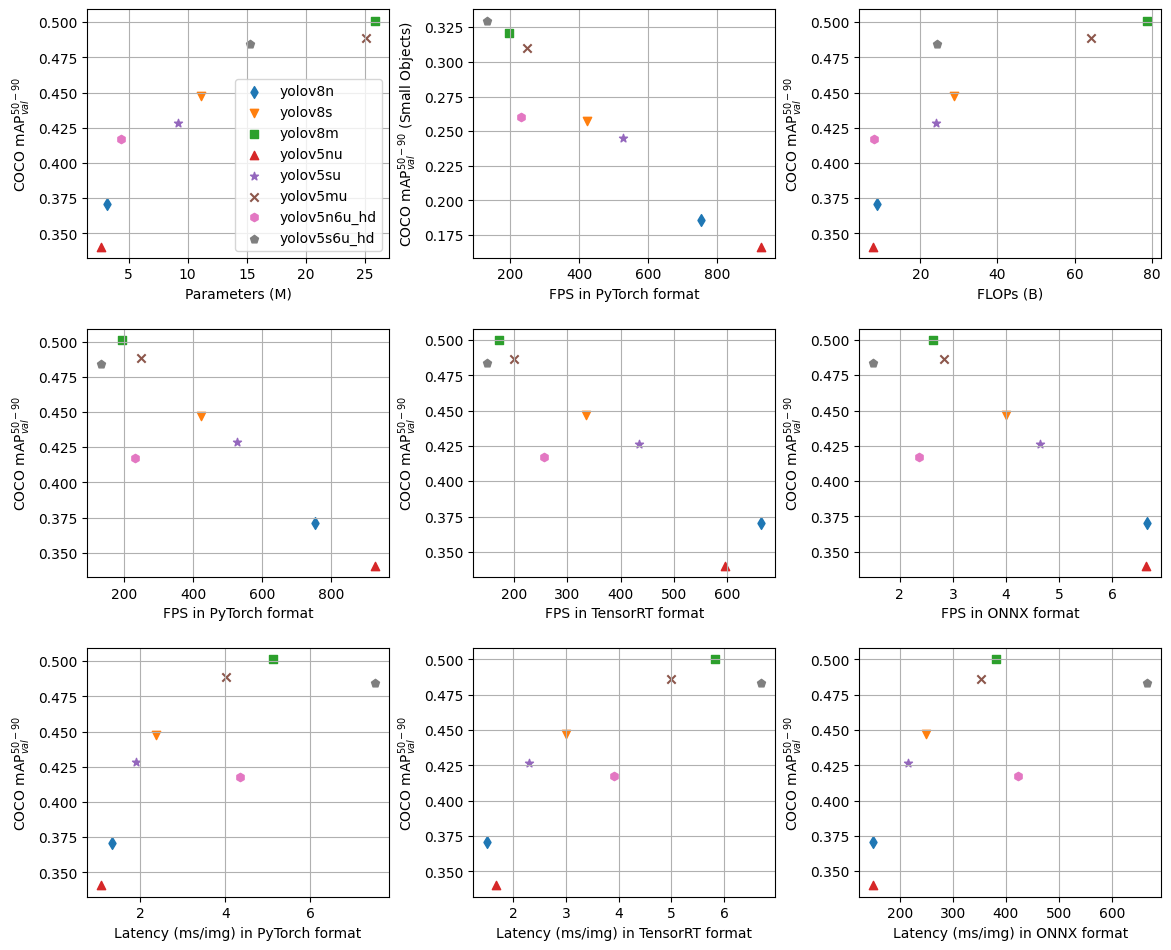

In [22]:
plot_benchmark(loaded_df, save=True)